In [1]:
!pip install -q kaggle

In [2]:
!mkdir ~/.kaggle
!cp kaggle(1).json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle(1).json

mkdir: cannot create directory ‘/root/.kaggle’: File exists
/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `cp kaggle(1).json ~/.kaggle/'
/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `chmod 600 /root/.kaggle/kaggle(1).json'


In [3]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
fer2013.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!unzip "/content/fer2013.zip"

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [5]:
train_directory = "/content/train"
val_directory = "/content/test"
CLASS_NAMES = ['angry','disgust','fear','happy','neutral','sad','surprise']
CONFIGURATION = {
    "BATCH_SIZE":16,
    "IM_SIZE":48,
    "LEARNING_RATE":0.001,
    "N_EPOCHS":50,
    "DROPOUT_RATE":0.1,
    "REGULARIZATION_RATE":0.0,
    "N_FILTERS":6,
    "KERNEL_SIZE":3,
    "N_STRIDES":1,
    "POOL_SIZE":2,
    "N_DENSE_1":150,
    "N_DENSE_2":50,
    "NUM_CLASSES":7
}

In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout,Layer,MaxPooling2D, GlobalAveragePooling2D, Add, Activation
from tensorflow.keras.regularizers import L2
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    width_shift_range = 0.1,        # Randomly shift the width of images by up to 10%
    height_shift_range = 0.1,       # Randomly shift the height of images by up to 10%
    horizontal_flip = True,         # Flip images horizontally at random
    rescale = 1./255,               # Rescale pixel values to be between 0 and 1
    validation_split = 0.2          # Set aside 20% of the data for validation
)

validation_datagen = ImageDataGenerator(
    rescale = 1./255,               # Rescale pixel values to be between 0 and 1
    validation_split = 0.2          # Set aside 20% of the data for validation
)


In [8]:
train_generator = train_datagen.flow_from_directory(directory = train_directory,
                                                    target_size = (CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )
validation_generator = validation_datagen.flow_from_directory( directory = val_directory,
                                                              target_size = (CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation")

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [9]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

def VGGnet(input_shape=(48, 48, 1), num_classes=7):
    inputs = layers.Input(shape=input_shape)

    # CONV BLOCK 1
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='block1_conv_2')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), name='block1_pool')(x)
    x = layers.Dropout(0.25)(x)

    # CONV BLOCK 2
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv_1')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), name='block2_pool')(x)
    x = layers.Dropout(0.25)(x)

    # CONV BLOCK 3
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv_1')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), name='block3_pool')(x)
    x = layers.Dropout(0.25)(x)

    # CONV BLOCK 4
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu', name='block4_conv_1')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), name='block4_pool')(x)
    x = layers.Dropout(0.25)(x)

    # CONV BLOCK 5
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu', name='block5_conv_1')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), name='block5_pool')(x)
    x = layers.Dropout(0.25)(x)

    # FULLY CONNECTED LAYERS
    x = layers.Flatten(name='flatten')(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0005), name='fully_connected_1')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.0005), name='fully_connected_2')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.25)(x)

    # OUTPUT LAYER
    outputs = layers.Dense(7, activation='softmax', name='output')(x)

    model = models.Model(inputs, outputs, name='VGGnet')
    return model

# Example usage:
model = VGGnet(input_shape=(48, 48, 1), num_classes=7)
model.summary()


Model: "VGGnet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv_2 (Conv2D)               │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv_1 (Conv2D)               │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv_1 (Conv2D)               │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv_1 (Conv2D)               │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 6, 6, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv_1 (Conv2D)               │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 3, 3, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │              

 Total params: 4,716,807 (17.99 MB)

 Trainable params: 4,710,791 (17.97 MB)

 Non-trainable params: 6,016 (23.50 KB)

In [14]:
from tensorflow.keras.optimizers import SGD
loss_function = CategoricalCrossentropy()
metrics = [CategoricalAccuracy(name='accuracy'),TopKCategoricalAccuracy(k=2,name='top_2_accuracy')]
model.compile(
    optimizer = Adam(learning_rate=0.001),
    loss = loss_function,
    metrics = metrics
)

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
    filepath="best_model_.h5",  # Save model as .h5 file
    monitor="val_accuracy",  # Monitor validation accuracy
    save_best_only=True,  # Save only the best model
    mode="max",  # Maximize val_accuracy
    verbose=1
)
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",  # Monitor validation loss
    factor=0.5,  # Reduce LR by 50% when needed
    patience=3,  # Wait 3 epochs before reducing
    min_lr=1e-6,  # Minimum LR to avoid too slow training
    verbose=1  # Print when LR is reduced
)
history = model.fit(x = train_generator,epochs = 100,validation_data = validation_generator,callbacks=[checkpoint_callback,reduce_lr])

Epoch 1/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.1986 - loss: 3.0303 - top_2_accuracy: 0.3630
Epoch 1: val_accuracy improved from -inf to 0.15712, saving model to best_model_.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 40s 77ms/step - accuracy: 0.1986 - loss: 3.0296 - top_2_accuracy: 0.3631 - val_accuracy: 0.1571 - val_loss: 2.5408 - val_top_2_accuracy: 0.3673 - learning_rate: 0.0010
Epoch 2/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.2501 - loss: 2.4578 - top_2_accuracy: 0.4379
Epoch 2: val_accuracy improved from 0.15712 to 0.34288, saving model to best_model_.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.2502 - loss: 2.4575 - top_2_accuracy: 0.4380 - val_accuracy: 0.3429 - val_loss: 2.3279 - val_top_2_accuracy: 0.5203 - learning_rate: 0.0010
Epoch 3/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3396 - loss: 2.1631 - top_2_accuracy: 0.5355
Epoch 3: val_accuracy improved from 0.34288 to 0.41201, saving model to best_model_.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.3397 - loss: 2.1629 - top_2_accuracy: 0.5356 - val_accuracy: 0.4120 - val_loss: 1.9261 - val_top_2_accuracy: 0.5922 - learning_rate: 0.0010
Epoch 4/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4068 - loss: 1.8914 - top_2_accuracy: 0.6075
Epoch 4: val_accuracy improved from 0.41201 to 0.41969, saving model to best_model_.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.4069 - loss: 1.8911 - top_2_accuracy: 0.6076 - val_accuracy: 0.4197 - val_loss: 1.8524 - val_top_2_accuracy: 0.6138 - learning_rate: 0.0010
Epoch 5/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4688 - loss: 1.6690 - top_2_accuracy: 0.6671
Epoch 5: val_accuracy improved from 0.41969 to 0.48883, saving model to best_model_.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.4688 - loss: 1.6688 - top_2_accuracy: 0.6671 - val_accuracy: 0.4888 - val_loss: 1.5385 - val_top_2_accuracy: 0.6941 - learning_rate: 0.0010
Epoch 6/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4845 - loss: 1.5515 - top_2_accuracy: 0.6858
Epoch 6: val_accuracy improved from 0.48883 to 0.51885, saving model to best_model_.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.4845 - loss: 1.5514 - top_2_accuracy: 0.6858 - val_accuracy: 0.5189 - val_loss: 1.4668 - val_top_2_accuracy: 0.6990 - learning_rate: 0.0010
Epoch 7/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5079 - loss: 1.4515 - top_2_accuracy: 0.7078
Epoch 7: val_accuracy did not improve from 0.51885
359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.5079 - loss: 1.4514 - top_2_accuracy: 0.7079 - val_accuracy: 0.4909 - val_loss: 1.4414 - val_top_2_accuracy: 0.7067 - learning_rate: 0.0010
Epoch 8/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5227 - loss: 1.3754 - top_2_accuracy: 0.7207
Epoch 8: val_accuracy improved from 0.51885 to 0.52723, saving model to best_model_.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.5227 - loss: 1.3753 - top_2_accuracy: 0.7207 - val_accuracy: 0.5272 - val_loss: 1.3308 - val_top_2_accuracy: 0.7304 - learning_rate: 0.0010
Epoch 9/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5305 - loss: 1.3458 - top_2_accuracy: 0.7265
Epoch 9: val_accuracy did not improve from 0.52723
359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.5305 - loss: 1.3458 - top_2_accuracy: 0.7265 - val_accuracy: 0.4574 - val_loss: 1.4697 - val_top_2_accuracy: 0.6704 - learning_rate: 0.0010
Epoch 10/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5488 - loss: 1.2974 - top_2_accuracy: 0.7432
Epoch 10: val_accuracy improved from 0.52723 to 0.57612, saving model to best_model_.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.5488 - loss: 1.2974 - top_2_accuracy: 0.7432 - val_accuracy: 0.5761 - val_loss: 1.2216 - val_top_2_accuracy: 0.7675 - learning_rate: 0.0010
Epoch 11/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5473 - loss: 1.2793 - top_2_accuracy: 0.7503
Epoch 11: val_accuracy improved from 0.57612 to 0.58310, saving model to best_model_.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.5473 - loss: 1.2793 - top_2_accuracy: 0.7503 - val_accuracy: 0.5831 - val_loss: 1.1791 - val_top_2_accuracy: 0.7709 - learning_rate: 0.0010
Epoch 12/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5511 - loss: 1.2621 - top_2_accuracy: 0.7514
Epoch 12: val_accuracy did not improve from 0.58310
359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.5511 - loss: 1.2621 - top_2_accuracy: 0.7514 - val_accuracy: 0.5559 - val_loss: 1.2341 - val_top_2_accuracy: 0.7605 - learning_rate: 0.0010
Epoch 13/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5582 - loss: 1.2454 - top_2_accuracy: 0.7587
Epoch 13: val_accuracy did not improve from 0.58310
359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.5582 - loss: 1.2454 - top_2_accuracy: 0.7587 - val_accuracy: 0.5272 - val_loss: 1.4343 - val_top_2_accuracy: 0.7011 - learning_rate: 0.0010
Epoch 14/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5572 - l

359/359 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.5573 - loss: 1.2553 - top_2_accuracy: 0.7552 - val_accuracy: 0.6068 - val_loss: 1.1498 - val_top_2_accuracy: 0.7744 - learning_rate: 0.0010
Epoch 15/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5746 - loss: 1.2231 - top_2_accuracy: 0.7595
Epoch 15: val_accuracy did not improve from 0.60684
359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.5746 - loss: 1.2231 - top_2_accuracy: 0.7595 - val_accuracy: 0.5992 - val_loss: 1.1337 - val_top_2_accuracy: 0.7870 - learning_rate: 0.0010
Epoch 16/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5760 - loss: 1.2088 - top_2_accuracy: 0.7694
Epoch 16: val_accuracy did not improve from 0.60684
359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.5760 - loss: 1.2088 - top_2_accuracy: 0.7694 - val_accuracy: 0.5873 - val_loss: 1.1973 - val_top_2_accuracy: 0.7640 - learning_rate: 0.0010
Epoch 17/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5818 - l

359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.6047 - loss: 1.1355 - top_2_accuracy: 0.8012 - val_accuracy: 0.6243 - val_loss: 1.0597 - val_top_2_accuracy: 0.8177 - learning_rate: 5.0000e-04
Epoch 20/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6139 - loss: 1.0893 - top_2_accuracy: 0.8034
Epoch 20: val_accuracy improved from 0.62430 to 0.64455, saving model to best_model_.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.6139 - loss: 1.0893 - top_2_accuracy: 0.8034 - val_accuracy: 0.6446 - val_loss: 1.0291 - val_top_2_accuracy: 0.8149 - learning_rate: 5.0000e-04
Epoch 21/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6234 - loss: 1.0657 - top_2_accuracy: 0.8112
Epoch 21: val_accuracy did not improve from 0.64455
359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.6234 - loss: 1.0657 - top_2_accuracy: 0.8112 - val_accuracy: 0.6243 - val_loss: 1.0539 - val_top_2_accuracy: 0.8010 - learning_rate: 5.0000e-04
Epoch 22/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6285 - loss: 1.0613 - top_2_accuracy: 0.8114
Epoch 22: val_accuracy did not improve from 0.64455
359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.6285 - loss: 1.0612 - top_2_accuracy: 0.8114 - val_accuracy: 0.6306 - val_loss: 1.0575 - val_top_2_accuracy: 0.8017 - learning_rate: 5.0000e-04
Epoch 23/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy

359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.6312 - loss: 1.0482 - top_2_accuracy: 0.8142 - val_accuracy: 0.6515 - val_loss: 1.0169 - val_top_2_accuracy: 0.8226 - learning_rate: 5.0000e-04
Epoch 24/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6408 - loss: 1.0237 - top_2_accuracy: 0.8266
Epoch 24: val_accuracy did not improve from 0.65154
359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.6408 - loss: 1.0237 - top_2_accuracy: 0.8266 - val_accuracy: 0.6355 - val_loss: 1.0582 - val_top_2_accuracy: 0.7989 - learning_rate: 5.0000e-04
Epoch 25/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6412 - loss: 1.0091 - top_2_accuracy: 0.8305
Epoch 25: val_accuracy did not improve from 0.65154
359/359 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.6412 - loss: 1.0092 - top_2_accuracy: 0.8305 - val_accuracy: 0.6453 - val_loss: 1.0039 - val_top_2_accuracy: 0.8254 - learning_rate: 5.0000e-04
Epoch 26/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy

359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.6584 - loss: 0.9695 - top_2_accuracy: 0.8371 - val_accuracy: 0.6648 - val_loss: 0.9705 - val_top_2_accuracy: 0.8268 - learning_rate: 2.5000e-04
Epoch 30/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6704 - loss: 0.9405 - top_2_accuracy: 0.8440
Epoch 30: val_accuracy did not improve from 0.66480
359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.6704 - loss: 0.9405 - top_2_accuracy: 0.8440 - val_accuracy: 0.6620 - val_loss: 0.9671 - val_top_2_accuracy: 0.8296 - learning_rate: 2.5000e-04
Epoch 31/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6650 - loss: 0.9358 - top_2_accuracy: 0.8418
Epoch 31: val_accuracy did not improve from 0.66480
359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.6650 - loss: 0.9358 - top_2_accuracy: 0.8418 - val_accuracy: 0.6599 - val_loss: 0.9858 - val_top_2_accuracy: 0.8289 - learning_rate: 2.5000e-04
Epoch 32/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy

359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.6731 - loss: 0.9153 - top_2_accuracy: 0.8526 - val_accuracy: 0.6718 - val_loss: 0.9464 - val_top_2_accuracy: 0.8338 - learning_rate: 2.5000e-04
Epoch 33/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6739 - loss: 0.9181 - top_2_accuracy: 0.8474
Epoch 33: val_accuracy did not improve from 0.67179
359/359 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.6739 - loss: 0.9181 - top_2_accuracy: 0.8474 - val_accuracy: 0.6585 - val_loss: 0.9667 - val_top_2_accuracy: 0.8219 - learning_rate: 2.5000e-04
Epoch 34/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6734 - loss: 0.9124 - top_2_accuracy: 0.8558
Epoch 34: val_accuracy improved from 0.67179 to 0.67249, saving model to best_model_.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.6734 - loss: 0.9123 - top_2_accuracy: 0.8558 - val_accuracy: 0.6725 - val_loss: 0.9681 - val_top_2_accuracy: 0.8380 - learning_rate: 2.5000e-04
Epoch 35/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6779 - loss: 0.9036 - top_2_accuracy: 0.8622
Epoch 35: val_accuracy did not improve from 0.67249

Epoch 35: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.6779 - loss: 0.9036 - top_2_accuracy: 0.8621 - val_accuracy: 0.6578 - val_loss: 0.9784 - val_top_2_accuracy: 0.8226 - learning_rate: 2.5000e-04
Epoch 36/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6935 - loss: 0.8724 - top_2_accuracy: 0.8606
Epoch 36: val_accuracy improved from 0.67249 to 0.67737, saving model to best_model_.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.6934 - loss: 0.8724 - top_2_accuracy: 0.8606 - val_accuracy: 0.6774 - val_loss: 0.9413 - val_top_2_accuracy: 0.8310 - learning_rate: 1.2500e-04
Epoch 37/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6848 - loss: 0.8724 - top_2_accuracy: 0.8645
Epoch 37: val_accuracy did not improve from 0.67737
359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.6849 - loss: 0.8724 - top_2_accuracy: 0.8645 - val_accuracy: 0.6683 - val_loss: 0.9615 - val_top_2_accuracy: 0.8282 - learning_rate: 1.2500e-04
Epoch 38/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6929 - loss: 0.8640 - top_2_accuracy: 0.8604
Epoch 38: val_accuracy did not improve from 0.67737
359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.6928 - loss: 0.8640 - top_2_accuracy: 0.8604 - val_accuracy: 0.6767 - val_loss: 0.9447 - val_top_2_accuracy: 0.8366 - learning_rate: 1.2500e-04
Epoch 39/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy

359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.6943 - loss: 0.8531 - top_2_accuracy: 0.8636 - val_accuracy: 0.6781 - val_loss: 0.9351 - val_top_2_accuracy: 0.8345 - learning_rate: 6.2500e-05
Epoch 41/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7071 - loss: 0.8165 - top_2_accuracy: 0.8784
Epoch 41: val_accuracy did not improve from 0.67807
359/359 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.7071 - loss: 0.8165 - top_2_accuracy: 0.8784 - val_accuracy: 0.6774 - val_loss: 0.9254 - val_top_2_accuracy: 0.8380 - learning_rate: 6.2500e-05
Epoch 42/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6985 - loss: 0.8402 - top_2_accuracy: 0.8693
Epoch 42: val_accuracy improved from 0.67807 to 0.68156, saving model to best_model_.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.6986 - loss: 0.8402 - top_2_accuracy: 0.8694 - val_accuracy: 0.6816 - val_loss: 0.9318 - val_top_2_accuracy: 0.8401 - learning_rate: 6.2500e-05
Epoch 43/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7054 - loss: 0.8223 - top_2_accuracy: 0.8748
Epoch 43: val_accuracy did not improve from 0.68156
359/359 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.7054 - loss: 0.8223 - top_2_accuracy: 0.8748 - val_accuracy: 0.6774 - val_loss: 0.9259 - val_top_2_accuracy: 0.8401 - learning_rate: 6.2500e-05
Epoch 44/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7089 - loss: 0.8190 - top_2_accuracy: 0.8721
Epoch 44: val_accuracy improved from 0.68156 to 0.68296, saving model to best_model_.h5



Epoch 44: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.7089 - loss: 0.8190 - top_2_accuracy: 0.8721 - val_accuracy: 0.6830 - val_loss: 0.9321 - val_top_2_accuracy: 0.8401 - learning_rate: 6.2500e-05
Epoch 45/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7098 - loss: 0.8126 - top_2_accuracy: 0.8750
Epoch 45: val_accuracy did not improve from 0.68296
359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.7098 - loss: 0.8126 - top_2_accuracy: 0.8750 - val_accuracy: 0.6809 - val_loss: 0.9242 - val_top_2_accuracy: 0.8338 - learning_rate: 3.1250e-05
Epoch 46/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7069 - loss: 0.8010 - top_2_accuracy: 0.8746
Epoch 46: val_accuracy did not improve from 0.68296
359/359 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.7069 - loss: 0.8011 - top_2_accuracy: 0.8746 - val_accuracy: 0.6830 - val_loss: 0.9158 - val_top_2_accuracy: 0.8394 - learning_rate

359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.7123 - loss: 0.7957 - top_2_accuracy: 0.8808 - val_accuracy: 0.6837 - val_loss: 0.9194 - val_top_2_accuracy: 0.8387 - learning_rate: 7.8125e-06
Epoch 57/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7155 - loss: 0.7879 - top_2_accuracy: 0.8829
Epoch 57: val_accuracy did not improve from 0.68366

Epoch 57: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.7155 - loss: 0.7879 - top_2_accuracy: 0.8829 - val_accuracy: 0.6774 - val_loss: 0.9200 - val_top_2_accuracy: 0.8401 - learning_rate: 7.8125e-06
Epoch 58/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7134 - loss: 0.7882 - top_2_accuracy: 0.8782
Epoch 58: val_accuracy did not improve from 0.68366
359/359 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.7134 - loss: 0.7881 - top_2_accuracy: 0.8782 - val_accuracy: 0.6774 - val_loss: 0.9198 - val_top_2_accuracy: 0.8401 - learning_rate

359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.7172 - loss: 0.7833 - top_2_accuracy: 0.8801 - val_accuracy: 0.6844 - val_loss: 0.9201 - val_top_2_accuracy: 0.8415 - learning_rate: 1.0000e-06
Epoch 65/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7215 - loss: 0.7799 - top_2_accuracy: 0.8814
Epoch 65: val_accuracy did not improve from 0.68436
359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.7215 - loss: 0.7800 - top_2_accuracy: 0.8814 - val_accuracy: 0.6788 - val_loss: 0.9201 - val_top_2_accuracy: 0.8401 - learning_rate: 1.0000e-06
Epoch 66/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7152 - loss: 0.7880 - top_2_accuracy: 0.8801
Epoch 66: val_accuracy did not improve from 0.68436
359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.7152 - loss: 0.7879 - top_2_accuracy: 0.8801 - val_accuracy: 0.6816 - val_loss: 0.9196 - val_top_2_accuracy: 0.8408 - learning_rate: 1.0000e-06
Epoch 67/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy

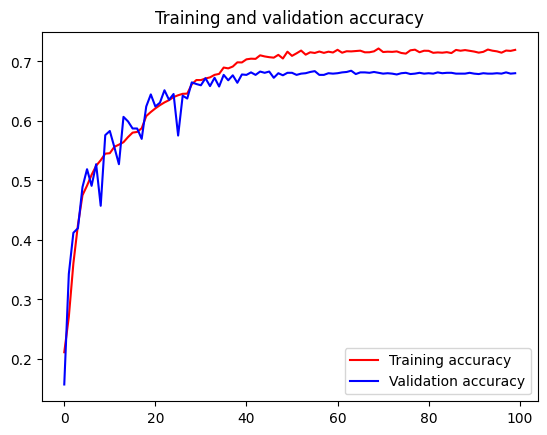

<Figure size 640x480 with 0 Axes>

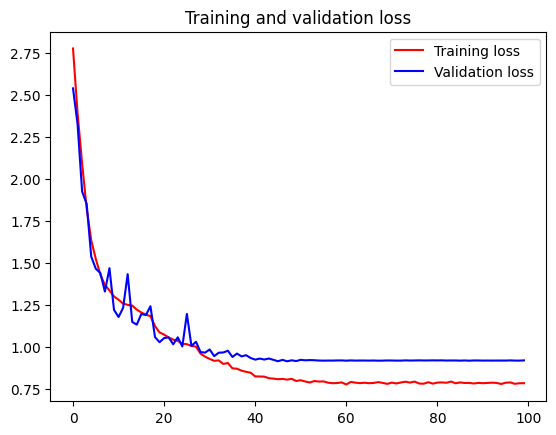

In [16]:
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

In [17]:
backbone = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    )

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
train_loss, train_acc,train_top2_acc = model.evaluate(train_generator)
test_loss, test_acc,test_top2_acc   = model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.7815 - loss: 0.6174 - top_2_accuracy: 0.9250
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6784 - loss: 0.9214 - top_2_accuracy: 0.8455
final train accuracy = 78.07 , validation accuracy = 68.02
